<a href="https://colab.research.google.com/github/arkeodev/demistify_deep_learning_applications/blob/main/Demistifying_Image_Segmentation_for_myself.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demistifying Image Segmentation for myself

## Imports

In [74]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import cv2
from scipy import ndimage
from google.colab.patches import cv2_imshow
from skimage.color import rgb2gray
from sklearn.cluster import KMeans

## Device (CPU vs GPU)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device} device')

Using cpu device


## Understanding Image Segmentation



Image segmentation is a fundamental process in computer vision that involves partitioning an image into multiple segments or regions, with the aim of simplifying its representation into something that is more meaningful and easier to analyze. This process enables the classification of each pixel in an image into a predefined set of categories, effectively allowing for the detailed labeling of different parts of the image based on the characteristics they exhibit.

The importance of image segmentation in computer vision stems from its ability to facilitate the extraction of valuable information from images, which is crucial for a wide range of applications. It enables the precise localization and recognition of objects within an image, supports the analysis of complex scenes, and plays a critical role in tasks such as object detection, medical imaging, autonomous driving, and augmented reality. By providing a pixel-wise classification of images, image segmentation allows for detailed analysis and interpretation, which is essential for understanding the content of images at a granular level and making informed decisions based on visual data.

In essence, image segmentation enhances the capabilities of computer vision systems by enabling them to dissect images into constituent parts or objects, making it possible to process and analyze images in a way that mimics human vision. This not only broadens the applicability of computer vision across various domains but also improves the accuracy and efficiency of tasks that rely on detailed image analysis.

## Types of Image Segmentation


Image segmentation can be categorized into several types, each serving different purposes and employing various methodologies to segment images.


The distinctions among these segmentation types lie in their approach to classifying and distinguishing the elements within an image. While semantic segmentation provides a broad understanding of the scene, instance segmentation adds another layer by identifying individual objects. Panoptic segmentation merges these concepts to offer a complete picture, classifying every part of the image and identifying individual instances within the classified categories.

![Types of image segmentation](https://raw.githubusercontent.com/arkeodev/demistify_deep_learning_applications/main/images/types-of-image-segmentation.jpg#:~:text=Copy-,permalink,-%E2%8C%98)

&nbsp;

Here are the main types of image segmentation:



### Semantic Segmentation


**Definition:** Semantic segmentation involves labeling each pixel in an image with a class from a predefined set of categories.

This type of segmentation does not differentiate between instances of the same class; for example, if an image contains multiple cars, all cars would be labeled with the same class without distinguishing between them.

**Use Cases:** Useful in applications where the focus is on understanding the type of objects present in an image rather than their individual identities, such as land cover classification in satellite imagery.

### Instance Segmentation

**Definition:** Instance segmentation goes a step further than semantic segmentation by not only labeling each pixel with a class but also distinguishing between different instances of the same class. In the previous example, each car would be identified and labeled as a separate entity, allowing for individual recognition and analysis of each instance.


**Use Cases:** Essential for applications requiring precise identification and analysis of individual objects within the same category, such as counting the number of specific items in retail or tracking individuals in a crowd.

### Panoptic Segmentation

**Definition:** Panoptic segmentation combines elements of both semantic and instance segmentation. It aims to label every pixel in an image with a class (like semantic segmentation) and also differentiate between different instances of the same class (like instance segmentation). Panoptic segmentation acknowledges the importance of both "stuff" classes (amorphous regions of similar texture or material, such as grass or sky) and "thing" classes (countable objects, such as cars or people).

**Use Cases:** Useful in complex scene understanding tasks that require comprehensive segmentation of all objects and background elements in an image, including both countable objects and uncountable regions. This is particularly beneficial in autonomous driving and urban planning applications where detailed environmental understanding is crucial.

## Distinguishing Image Segmentation from Other Image Annotation Techniques

### Image Classification

**Objective:** Assigns a single label to an entire image based on its overall content. It does not provide information about the location or presence of multiple objects within the image.

**Comparison with Image Segmentation:** While image classification tells you what is present in an image broadly, image segmentation goes further by dividing the image into segments, classifying each pixel into a specific category, thus providing detailed information about the shape, location, and boundary of objects within the image

### Object Detection

**Objective:** Identifies objects within an image and provides a bounding box around each object, along with a class label for each detected object. It can detect multiple objects and their locations within the same image.

**Comparison with Image Segmentation:** Object detection identifies the presence and location of objects but does not delineate their precise boundaries. In contrast, image segmentation provides pixel-level classification, which includes detailed boundaries and shapes of objects.

### Localization

**Objective:** Similar to object detection but typically focused on finding the location of a single object within an image. Localization provides the bounding box coordinates of the object of interest.

**Comparison with Image Segmentation:** Localization identifies the location of an object within an image, which is a simpler task compared to segmentation. Image segmentation not only locates objects within an image but also provides detailed information on the extent and shape of each object at the pixel level

### Summary

**Image Classification** tells you what the image contains but not where the objects are or how many.

**Localization** provides the location of a single main object in the image without specifying its exact outline.

**Object Detection** extends localization to multiple objects, identifying their locations with bounding boxes but not their precise shapes.

**Image Segmentation** offers the most detailed information by classifying every pixel of the image, revealing not just what objects are present and where, but also providing precise outlines of each object.

Image segmentation is therefore the most informative among these tasks, providing detailed analysis that is particularly useful in applications requiring precise object outlines, such as medical imaging, autonomous driving, and detailed scene understanding.

![Distinguishing Image Segmentation from Other Image Annotation Techniques](https://raw.githubusercontent.com/arkeodev/demistify_deep_learning_applications/main/images/difference-between-classification-localization-detection-and-segmentation.png#:~:text=Copy-,permalink,-%E2%8C%98)

## Exploring Image Segmentation Techniques

Image segmentation encompasses a variety of techniques, each employing different methodologies to partition images into meaningful segments. The main techniques used in image segmentation include thresholding, clustering, edge detection, region-based segmentation, and deep learning-based methods. Here's how they differ:

### Region-Based Segmentation


**Methodology:** With this first technique, similarities are detected in the pixels of segments in direct proximity to one another. The pixels that are nearest to each other are more likely to be a part of the same object which is why this technique analyzes the similarities and differences of adjacent pixels and determines the boundaries of the given object. One shortcoming of this technique is that lighting and contrast within the image may lead to inaccurate defining of the object parameters.

### Thresholding


**Methodology:** Divides an image into foreground and background by applying a threshold to the pixel intensity values. Pixels above the threshold are classified as foreground, while those below are classified as background. Thresholding can be global (single threshold for the whole image) or adaptive (threshold varies across different image regions).

**Use Cases:** Simple applications where the objects of interest significantly differ in brightness from the background, such as document scanning or basic object detection.

In [37]:
import requests

def download_image(image_url, image_name):
    response = requests.get(image_url)
    if response.status_code == 200:
        with open(image_name, 'wb') as file:
            file.write(response.content)
    # Return the file name
    return image_name

(400, 500, 3)


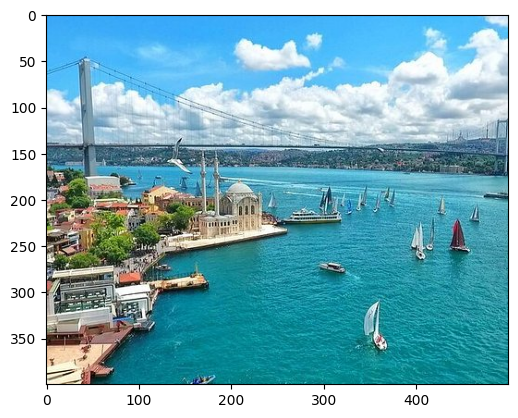

In [40]:
# Read the Istanbul image
image_url = "https://raw.githubusercontent.com/arkeodev/demistify_deep_learning_applications/main/images/istanbul.jpg"
image_name = "istanbul.jpg"
image_ist = plt.imread(download_image(image_url, image_name))
print(image_ist.shape)
plt.imshow(image_ist)

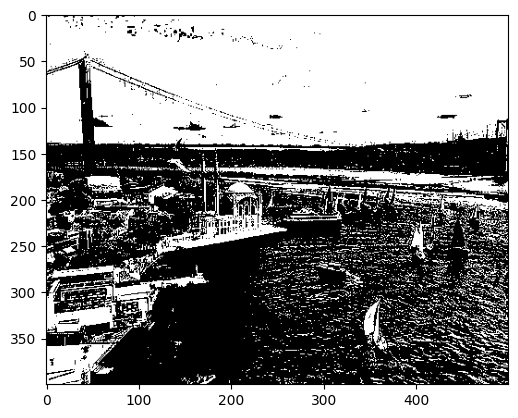

In [51]:
# Here we determine the average value of the pixels as threshold
gray_ist = rgb2gray(image_ist)

# Flatten the grayscale image for processing
gray_ist_reducted = gray_ist.reshape(-1)

for i in range(gray_ist_reducted.shape[0]):
    if gray_ist_reducted[i] > gray_ist_reducted.mean():
        gray_ist_reducted[i] = 1
    else:
        gray_ist_reducted[i] = 0

gray_ist = gray_ist_reducted.reshape(image_ist.shape[0],image_ist.shape[1])
plt.imshow(gray_ist, cmap='gray')

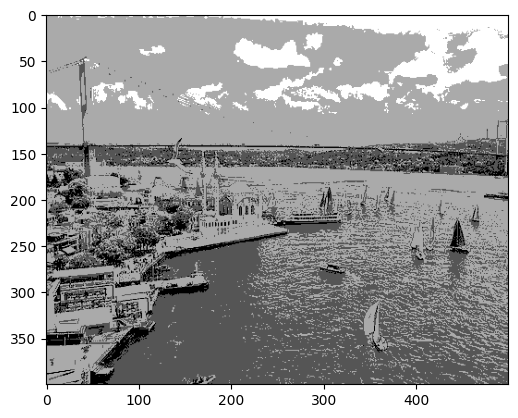

In [50]:
# Here we have three thresholds. Average, 0.5 and 0.25.
gray_ist = rgb2gray(image_ist)

# Flatten the grayscale image for processing
gray_ist_reducted = gray_ist.reshape(-1)

for i in range(gray_ist_reducted.shape[0]):
    if gray_ist_reducted[i] > gray_ist_reducted.mean():
        gray_ist_reducted[i] = 3
    elif gray_ist_reducted[i] > 0.5:
        gray_ist_reducted[i] = 2
    elif gray_ist_reducted[i] > 0.25:
        gray_ist_reducted[i] = 1
    else:
        gray_ist_reducted[i] = 0

gray_ist = gray_ist_reducted.reshape(image_ist.shape[0], image_ist.shape[1])
plt.imshow(gray_ist, cmap='gray')

### Edge Detection Segmentation

**Methodology:** Identifies the boundaries between objects in an image by detecting sharp changes in intensity. Algorithms like Sobel, Canny, and Prewitt are used to highlight edges. The segmentation is performed by outlining the shape of objects based on the detected edges.

**Use Cases:** Applications where the outline of objects is more important than their internal texture or color, such as identifying the shape of objects in an industrial inspection.

(1200, 1200, 3)


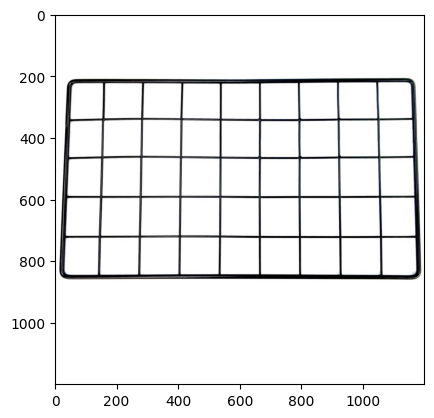

In [52]:
# Read the Istanbul image
image_url = "https://raw.githubusercontent.com/arkeodev/demistify_deep_learning_applications/main/images/grid.jpg"
image_name = "grid.jpg"
image_grid = plt.imread(download_image(image_url, image_name))
print(image_grid.shape)
plt.imshow(image_grid)

In [53]:
# Convert the image to the gray form
gray = rgb2gray(image_grid)

In [54]:
# defining the sobel filters
sobel_horizontal = np.array([np.array([1, 2, 1]), np.array([0, 0, 0]), np.array([-1, -2, -1])])
print(sobel_horizontal, 'is a kernel for detecting horizontal edges')

sobel_vertical = np.array([np.array([-1, 0, 1]), np.array([-2, 0, 2]), np.array([-1, 0, 1])])
print(sobel_vertical, 'is a kernel for detecting vertical edges')

[[ 1  2  1]
 [ 0  0  0]
 [-1 -2 -1]] is a kernel for detecting horizontal edges
[[-1  0  1]
 [-2  0  2]
 [-1  0  1]] is a kernel for detecting vertical edges


In [55]:
out_h = ndimage.convolve(gray, sobel_horizontal, mode='reflect')
out_v = ndimage.convolve(gray, sobel_vertical, mode='reflect')
# here mode determines how the input array is extended when the filter overlaps a border.

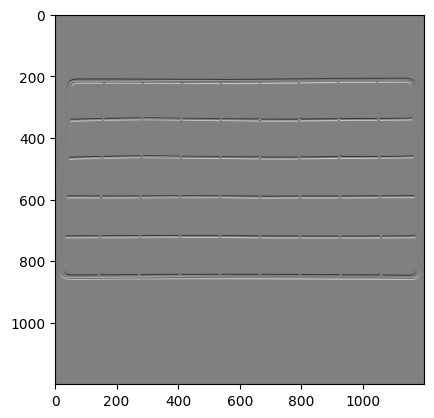

In [56]:
plt.imshow(out_h, cmap='gray')

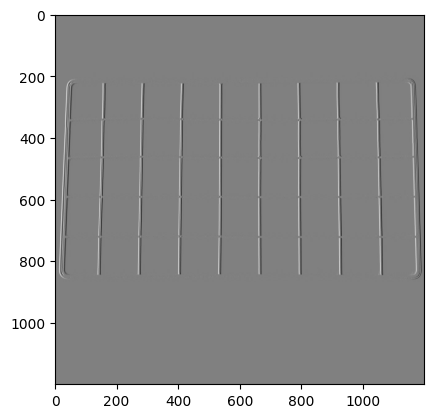

In [57]:
plt.imshow(out_v, cmap='gray')

In [65]:
# Defining the laplace filters. It shows both vertical and horizantal edges.
kernel_laplace = np.array([np.array([1, 1, 1]), np.array([1, -7, 1]), np.array([1, 1, 1])])
print(kernel_laplace, 'is a laplacian kernel')

[[ 1  1  1]
 [ 1 -7  1]
 [ 1  1  1]] is a laplacian kernel


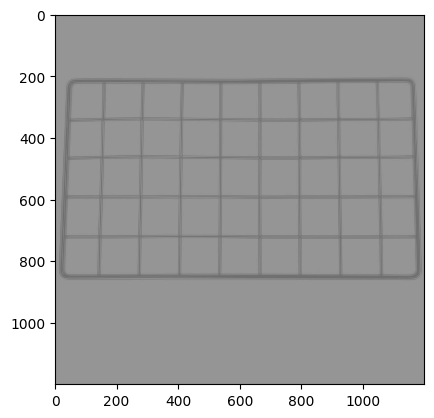

In [66]:
out_l = ndimage.convolve(gray, kernel_laplace, mode='reflect')
plt.imshow(out_l, cmap='gray')

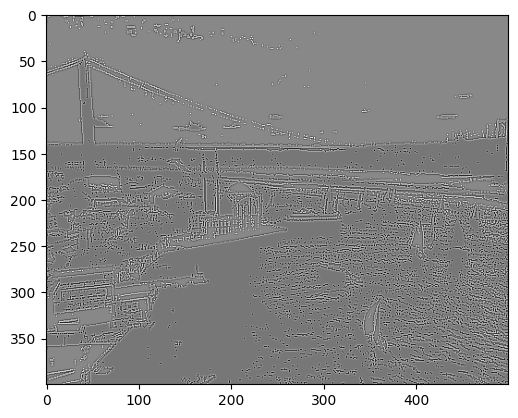

In [67]:
out_l_ist = ndimage.convolve(gray_ist, kernel_laplace, mode='reflect')
plt.imshow(out_l_ist, cmap='gray')

### Clustering Techniques

**Methodology:** Groups pixels into clusters based on their feature similarities, such as color or texture. K-means and Mean Shift are common clustering algorithms used for segmentation. The algorithm treats each pixel as a point in a feature space and partitions the image into clusters based on the proximity of these feature points.

**Use Cases:** Segmenting natural scenes where objects can be distinguished based on color or texture patterns, like segmenting different terrain types in satellite images.

(200000, 3)

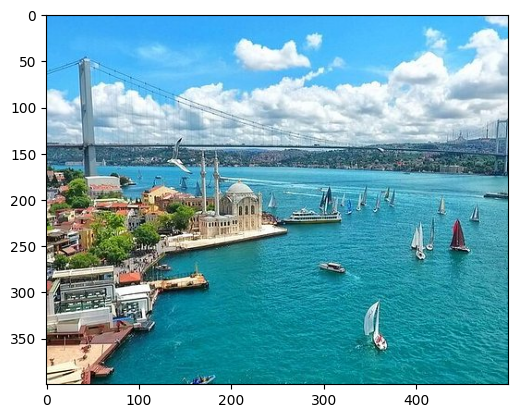

In [76]:
pic_cluster = image_ist/255  # dividing by 255 to bring the pixel values between 0 and 1
plt.imshow(pic_cluster)
pic_n = pic_cluster.reshape(pic_cluster.shape[0] * pic_cluster.shape[1], pic_cluster.shape[2])
pic_n.shape

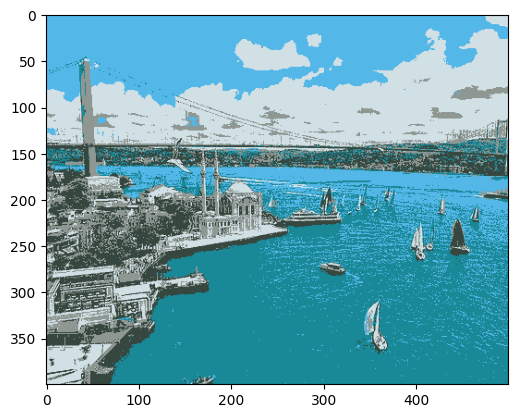

In [77]:
# Create 5 clusters of the pixels
kmeans = KMeans(n_clusters=5, random_state=0, n_init='auto').fit(pic_n)
pic2show = kmeans.cluster_centers_[kmeans.labels_]
cluster_pic = pic2show.reshape(pic_cluster.shape[0], pic_cluster.shape[1], pic_cluster.shape[2])
plt.imshow(cluster_pic)

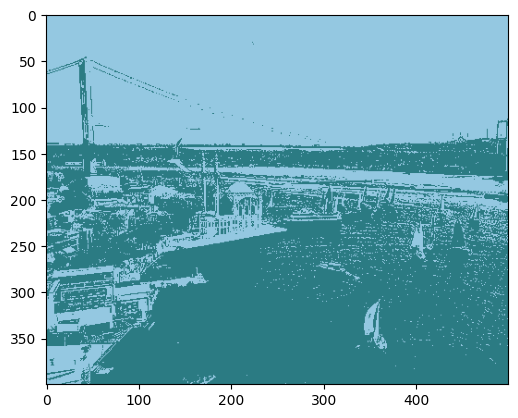

In [78]:
# Create 2 clusters of the pixels
kmeans = KMeans(n_clusters=2, random_state=0, n_init='auto').fit(pic_n)
pic2show = kmeans.cluster_centers_[kmeans.labels_]
cluster_pic = pic2show.reshape(pic_cluster.shape[0], pic_cluster.shape[1], pic_cluster.shape[2])
plt.imshow(cluster_pic)

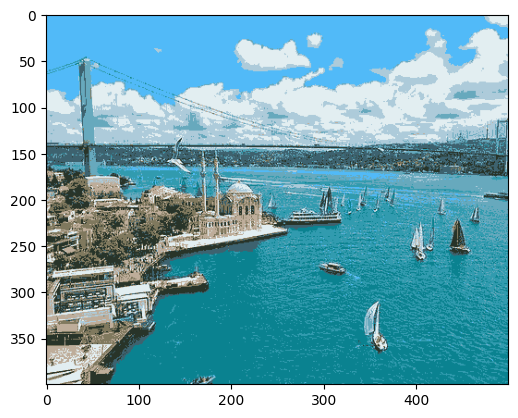

In [79]:
# Create 10 clusters of the pixels
kmeans = KMeans(n_clusters=10, random_state=0, n_init='auto').fit(pic_n)
pic2show = kmeans.cluster_centers_[kmeans.labels_]
cluster_pic = pic2show.reshape(pic_cluster.shape[0], pic_cluster.shape[1], pic_cluster.shape[2])
plt.imshow(cluster_pic)

### Depp-Learning Based Methods

**Methodology:** Utilizes convolutional neural networks (CNNs) to perform segmentation at a pixel level. Architectures like U-Net, SegNet, and DeepLab are trained on large datasets to learn complex features for accurate segmentation. These models often employ an encoder-decoder structure to capture both high-level semantic and low-level spatial information.

**Use Cases:** Advanced applications requiring high precision and context understanding, such as autonomous driving, detailed land use and land cover mapping, and precise medical diagnostic

## Leveraging Deep Learning for Enhanced Image Segmentation

### U-Net Architecture

### Mask R-CNN

### DeepLab Versions

### User-Interactive Segmentation Techniques

*  f-BRS
*  DEXTR

### Meta's Segment Anything Model (SAM)

## Public Datasets

* Pascal VOC Dataset
* MS COCO Dataset

## Evaluation

### Intersection Over Union (IOU)

## Applications of Image Segmentation

* Medical Imaging
* Video Surveillance
* Autonomous Vehicles
* Agriculture
* Satellite Imagery
* Robotics
* Art and Design
* Gaming
* Fashion and Retail

# Implementing U-Net for Image Segmentation

## Introduction to U-Net Architecture
- Briefly introduce what U-Net is and its significance.

## Preparing the Dataset
- Guidelines on dataset selection, preparation, and preprocessing.

## Model Architecture
- Detailed explanation of the U-Net model architecture.

## Training the U-Net Model
- Insights into training procedures, including choice of optimizers, loss functions, and training strategies.

### Loss Functions
- Discuss the common loss functions used in training U-Net models.

### Optimizers
- Overview of optimizers suitable for U-Net.

## Evaluating the Model
- Criteria and metrics for model evaluation, including IOU and other relevant metrics.

## Model Inference
- Guidelines on how to use the trained model for making predictions on new data.

## Optimization and Tuning
- Tips on fine-tuning and optimizing the model for better performance.

## Challenges and Solutions
- Discuss common challenges in training U-Net models and possible solutions.

## Conclusion

- Summarize key points and suggest directions for future research or application enhancements.

# References

- Types of image segmentation image: https://mindy-support.com/news-post/what-is-image-segmentation-the-basics-and-key-techniques/

- Image segmentation vs. object detection vs. image classification vs. localization image: Jaiswal, A., Babu, A. R., Zadeh, M. Z., Banerjee, D., &
Makedon, F. (2021). A survey on contrastive self-supervised learning Technologies: https://www.mdpi.com/2227-7080/9/1/2